# Machine Learning Engineer Nanodegree
## Capstone Project - Starbucks app data

In [1]:
import os
import numpy as np
import pandas as pd
import pprint
import json

from IPython.display import display
from lib.utils import assess_model

%load_ext autoreload
%autoreload 2

In [2]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
from sagemaker import LinearLearner
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner, CategoricalParameter
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

b_session = boto3.session.Session(region_name='eu-central-1')

session = sagemaker.Session(boto_session=b_session)
role = 'AmazonSageMaker-ExecutionRole-20191105T072928'

bucket = session.default_bucket()

# Part 4 - Data preprocessing

Before running some Machine Learning models, we have to go through some preparation steps on the data, as
- impute missing values
- encode categorical variables (*gender*)
- normalize feature distributions

To do so, we use the classical **scikit-learn** API and the **SKLearnProcessor** feature of AWS Sagemaker to run the job on the cloud.

In [4]:
output_configs = {}

for tgt in ['bogo', 'discount', 'info']:
    print(tgt)
    
    sklearn_processor = SKLearnProcessor(framework_version='0.20.0',
                                         role=role,
                                         instance_type='ml.m5.xlarge',
                                         instance_count=1)
    sklearn_processor.run(
        code='lib/preprocessing.py', #entrypoint for processing
        inputs=[ProcessingInput(os.path.join('s3://', bucket, f'Capstone_Starbucks/{tgt}.csv'), '/opt/ml/processing/input')],
        outputs=[
            ProcessingOutput(source=f'/opt/ml/processing/output/',
                             output_name=f'{tgt}_data')
        ],
        arguments=['--target', tgt]
     )

    preprocessing_job_description = sklearn_processor.jobs[-1].describe()
    output_configs[tgt] = preprocessing_job_description['ProcessingOutputConfig']

bogo

Job Name:  sagemaker-scikit-learn-2020-01-18-17-19-28-554
Inputs:  [{'InputName': 'input-1', 'S3Input': {'S3Uri': 's3://sagemaker-eu-central-1-601949536922/Capstone_Starbucks/bogo.csv', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'S3Input': {'S3Uri': 's3://sagemaker-eu-central-1-601949536922/sagemaker-scikit-learn-2020-01-18-17-19-28-554/input/code/preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'bogo_data', 'S3Output': {'S3Uri': 's3://sagemaker-eu-central-1-601949536922/sagemaker-scikit-learn-2020-01-18-17-19-28-554/output/bogo_data', 'LocalPath': '/opt/ml/processing/output/', 'S3UploadMode': 'EndOfJob'}}]
....................Collecting joblib
  Found existing installation

In [7]:
# Take the location on S3
preprocessed_data = {}
for output in output_configs:
            preprocessed_data[output] = output_configs[output]['Outputs'][0]['S3Output']['S3Uri']

# Move datasets to project specific directory
s3_client = boto3.client('s3')
for k in preprocessed_data:
    for f in ['train.csv', 'val.csv', 'test.csv', 'test_tgt.csv', 'transformer.joblib']:
        copy_source = {'Bucket': bucket, 'Key': '/'.join(preprocessed_data[k][5:].split('/')[1:] + [f'{k}_{f}'])}
        s3_client.copy_object(CopySource=copy_source, Bucket=bucket, Key=f'Capstone_Starbucks/{k}/{k}_{f}')

# Download all the new datasets
for k in preprocessed_data:
    for f in ['train.csv', 'val.csv', 'test.csv', 'test_tgt.csv']:
        session.download_data(f'./data/{k}/', bucket, f'Capstone_Starbucks/{k}/{k}_{f}')

# Part 5 - Machine Learning models

In [10]:
# This dataset will contain all the information about the developed models
best_model = {'bogo': {}, 'discount': {}, 'info': {}}

## XGBoost model
First, we develop a XGBoost model. We use the `HyperparameterTuner` object to find the most performing hyperparameters for each target.

In [28]:
# Set the model image
container = get_image_uri(session.boto_region_name, 'xgboost', '0.90-1')

for prefix in ['bogo', 'discount', 'info']:
    # Initialize XGBoost, with some hyperparameters
    xgb = sagemaker.estimator.Estimator(container,
                                        role,
                                        train_instance_count=1,
                                        train_instance_type='ml.c4.xlarge',
                                        output_path=f's3://{bucket}/Capstone_Starbucks/{prefix}/model',
                                        sagemaker_session=session,
                                        base_job_name=prefix + '-')
    xgb.set_hyperparameters(max_depth=4,
                            eta=0.1,
                            gamma=4,
                            min_child_weight=6,
                            colsample_bytree=0.5,
                            subsample=0.6,
                            early_stopping_rounds=10,
                            num_round=200,
                            seed=1123)

    # Initialize tuner
    xgb_hyperparameter_tuner = HyperparameterTuner(estimator=xgb,
                                                   objective_metric_name='validation:f1',
                                                   objective_type='Maximize',
                                                   max_jobs=20,
                                                   max_parallel_jobs=4,
                                                   hyperparameter_ranges = {
                                                        'max_depth': IntegerParameter(2, 6),
                                                        'eta'      : ContinuousParameter(0.01, 0.5),
                                                        'gamma': ContinuousParameter(0, 10),
                                                        'min_child_weight': IntegerParameter(2, 8),
                                                        'colsample_bytree': ContinuousParameter(0.2, 1.0),
                                                        'subsample': ContinuousParameter(0.3, 1.0),
                                                   },
                                                   base_tuning_job_name=prefix + '-xgb-tuning')

    # Take train and validation location in S3
    s3_input_train = sagemaker.s3_input(s3_data=f's3://{bucket}/Capstone_Starbucks/{prefix}/{prefix}_train.csv', content_type='csv')
    s3_input_validation = sagemaker.s3_input(s3_data=f's3://{bucket}/Capstone_Starbucks/{prefix}/{prefix}_val.csv', content_type='csv')

    # Fit tuner
    xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})
    
    print(f'Waiting {prefix}...')
    xgb_hyperparameter_tuner.wait()

    # Save results and best model
    best_model[prefix]['xgb'] = {'name': xgb_hyperparameter_tuner.best_training_job(),
                                 'value': xgb_hyperparameter_tuner.analytics().dataframe()['FinalObjectiveValue'].max()}

Waiting bogo...
.......................!
2020-01-19 19:25:51 Starting - Preparing the instances for training
2020-01-19 19:25:51 Downloading - Downloading input data
2020-01-19 19:25:51 Training - Training image download completed. Training in progress.
2020-01-19 19:25:51 Uploading - Uploading generated training model
2020-01-19 19:25:51 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:f1 to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[19:25:41] 14980x15 matrix with 224700 entries loaded from /opt/ml/input/data/train?format=cs

KeyboardInterrupt: 

In [47]:
# Now we re-train the best model
for prefix in ['bogo', 'discount', 'info']:
    print(prefix)
    
    tuner = sagemaker.estimator.Estimator.attach(best_model[prefix]['xgb']['name'])
    
    s3_input_train = sagemaker.s3_input(s3_data=f's3://{bucket}/Capstone_Starbucks/{prefix}/{prefix}_train.csv', content_type='csv')
    s3_input_validation = sagemaker.s3_input(s3_data=f's3://{bucket}/Capstone_Starbucks/{prefix}/{prefix}_val.csv', content_type='csv')

    tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

    best_model[prefix]['xgb']['model'] = tuner

bogo
2020-01-19 19:28:36 Starting - Preparing the instances for training
2020-01-19 19:28:36 Downloading - Downloading input data
2020-01-19 19:28:36 Training - Training image download completed. Training in progress.
2020-01-19 19:28:36 Uploading - Uploading generated training model
2020-01-19 19:28:36 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:f1 to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[19:28:26] 14980x15 matrix with 224700 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:ro

## Linear Learner 
The second algorithm is the Sagemaker's `LinearLearner`. Here we set a series of hyperparameters as the default ones.

In [38]:
for prefix in ['bogo', 'discount', 'info']:
    # Create instance of LinearLearner
    ll = LinearLearner(role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       predictor_type='binary_classifier',
                       output_path='s3://{}/Capstone_Starbucks/{}/model'.format(bucket, prefix),
                       sagemaker_session=session,
                       binary_classifier_model_selection_criteria='f1',
                       epochs=100,
                       use_bias=True,
                       optimizer='adam',
                       loss='auto',
                       wd=0,
                       normalize_data=True,
                       unbias_data=True,
                       early_stopping_patience=5,
                       learning_rate=0.01,
                       balance_multiclass_weights=True)
    
    # Create record sets from local data as inputs to the LinearLearner
    train = pd.read_csv(f'./data/{prefix}/{prefix}_train.csv', header=None)
    train_data = ll.record_set(train.drop(0, 1).values.astype('float32'), labels=train[0].values.astype('float32'),
                                         channel='train')
    
    valid = pd.read_csv(f'./data/{prefix}/{prefix}_train.csv', header=None)
    validation_data = ll.record_set(valid.drop(0, 1).values.astype('float32'), labels=valid[0].values.astype('float32'),
                                         channel='validation')

    # Fit the model
    ll.fit([train_data, validation_data], logs=False)

    # Save results
    tja = ll.training_job_analytics
    res = tja.dataframe()
    best_model[prefix]['ll'] = {'name': tja.name,
                                'value': res.loc[res['metric_name'] == 'validation:binary_f_beta', 'value'].values[0],
                                'model': ll}


2020-01-19 21:03:05 Starting - Starting the training job
2020-01-19 21:03:07 Starting - Launching requested ML instances..........
2020-01-19 21:04:05 Starting - Preparing the instances for training........
2020-01-19 21:04:48 Downloading - Downloading input data.....
2020-01-19 21:05:18 Training - Downloading the training image..
2020-01-19 21:05:31 Training - Training image download completed. Training in progress........................
2020-01-19 21:07:35 Uploading - Uploading generated training model
2020-01-19 21:07:35 Completed - Training job completed


2020-01-19 21:07:41 Starting - Starting the training job
2020-01-19 21:07:42 Starting - Launching requested ML instances................
2020-01-19 21:09:08 Starting - Preparing the instances for training............
2020-01-19 21:10:13 Downloading - Downloading input data....
2020-01-19 21:10:42 Training - Downloading the training image..
2020-01-19 21:10:58 Training - Training image download completed. Training in progress...................
2020-01-19 21:12:29 Uploading - Uploading generated training model
2020-01-19 21:12:36 Completed - Training job completed



2020-01-19 21:12:42 Starting - Starting the training job
2020-01-19 21:12:44 Starting - Launching requested ML instances..........
2020-01-19 21:13:43 Starting - Preparing the instances for training............
2020-01-19 21:14:45 Downloading - Downloading input data...
2020-01-19 21:15:06 Training - Downloading the training image.
2020-01-19 21:15:18 Training - Training image download completed. Training in progress..............
2020-01-19 21:16:30 Uploading - Uploading generated training model.
2020-01-19 21:16:36 Completed - Training job completed


These are the results of all the trainings on the 3 targets.

In [48]:
pprint.pprint(best_model)

{'bogo': {'ll': {'model': <sagemaker.amazon.linear_learner.LinearLearner object at 0x1a2bf6f048>,
                 'name': 'linear-learner-2020-01-19-21-03-04-196',
                 'value': 0.713481285194},
          'xgb': {'model': <sagemaker.estimator.Estimator object at 0x1a2aa72ef0>,
                  'name': 'bogo-xgb-tuning-200119-2019-010-fda6afaf',
                  'value': 0.7365909814834595}},
 'discount': {'ll': {'model': <sagemaker.amazon.linear_learner.LinearLearner object at 0x1a2bf6fe10>,
                     'name': 'linear-learner-2020-01-19-21-07-40-495',
                     'value': 0.709247431269},
              'xgb': {'model': <sagemaker.estimator.Estimator object at 0x1a282b7e80>,
                      'name': 'discount-xgb-tuning-200118-2242-018-7ec3639a',
                      'value': 0.7281720042228699}},
 'info': {'ll': {'model': <sagemaker.amazon.linear_learner.LinearLearner object at 0x1a2b500eb8>,
                 'name': 'linear-learner-2020-01-19-21

It seems that for **bogo** and **discount** offers the best model is XGBoost; for **informational** instead we should go with the LinearLearner. Let's look at the performances on the *test set*: we use the `BatchTransform` method to obtain predictions on this dataset.

In [51]:
for prefix in ['bogo','discount', 'info']:
    print(prefix)

    # Create XGB transformer
    transformer = best_model[prefix]['ll']['model'].transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

    # Batch transform
    transformer.transform(f's3://{bucket}/Capstone_Starbucks/{prefix}/{prefix}_test.csv',
                                       content_type='text/csv', split_type='Line', logs=False)
    
    transformer.wait(logs=False)
    
    # Download data
    session.download_data(f'./data/{prefix}/{prefix}_ll_preds', bucket,
                          key_prefix='/'.join(transformer.output_path.split('/')[3:]))
    
    # Create LinearLearner transformer
    transformer = best_model[prefix]['xgb']['model'].transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

    # Batch transform
    transformer.transform(f's3://{bucket}/Capstone_Starbucks/{prefix}/{prefix}_test.csv',
                                       content_type='text/csv', split_type='Line', wait=True, logs=False)

    # Download data
    session.download_data(f'./data/{prefix}/{prefix}_xgb_preds', bucket,
                          key_prefix='/'.join(transformer.output_path.split('/')[3:]))

bogo


...........................................!
..........................................!
discount
...........................................!
..........................................!
info
..........................................!
..........................................!


Finally, let't take a look at the results, through a series of performance measures.

bogo
XGBoost


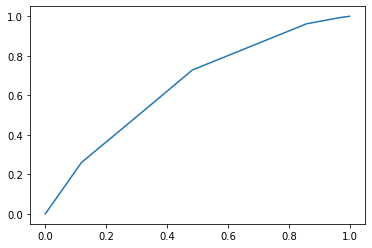

col_0,0,1
0,,
0.0,0.516822,0.483178
1.0,0.271963,0.728037


,value
accuracy,0.622430
balanced_accuracy,0.622430
precision,0.601080
recall,0.728037
f1,0.658495
average_precision,0.607123
AUC,0.651332


LinearLearner


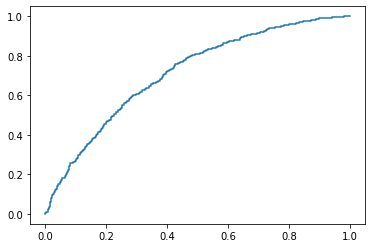

col_0,0.0,1.0
0,,
0.0,0.417757,0.582243
1.0,0.142056,0.857944


,value
accuracy,0.637850
balanced_accuracy,0.637850
precision,0.595717
recall,0.857944
f1,0.703179
average_precision,0.680886
AUC,0.712176





discount
XGBoost


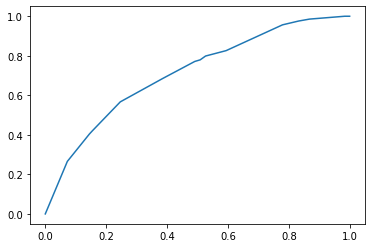

col_0,0,1
0,,
0.0,0.615137,0.384863
1.0,0.315620,0.684380


,value
accuracy,0.649758
balanced_accuracy,0.649758
precision,0.640060
recall,0.684380
f1,0.661479
average_precision,0.680164
AUC,0.712180


LinearLearner


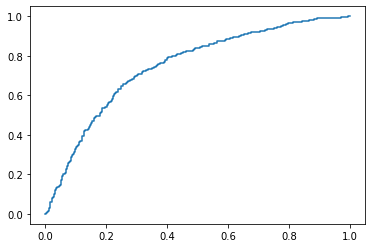

col_0,0.0,1.0
0,,
0.0,0.434783,0.565217
1.0,0.130435,0.869565


,value
accuracy,0.652174
balanced_accuracy,0.652174
precision,0.606061
recall,0.869565
f1,0.714286
average_precision,0.705664
AUC,0.746972





info
XGBoost


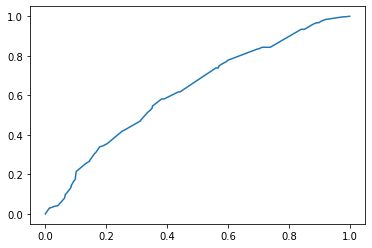

col_0,0,1
0,,
0.0,0.609890,0.390110
1.0,0.418733,0.581267


,value
accuracy,0.595598
balanced_accuracy,0.595579
precision,0.597734
recall,0.581267
f1,0.589385
average_precision,0.592517
AUC,0.624792


LinearLearner


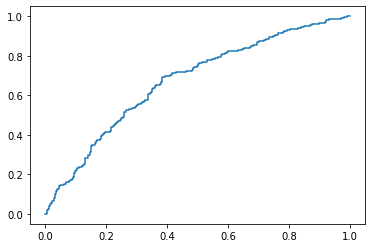

col_0,0.0,1.0
0,,
0.0,0.189560,0.810440
1.0,0.066116,0.933884


,value
accuracy,0.561210
balanced_accuracy,0.561722
precision,0.534700
recall,0.933884
f1,0.680040
average_precision,0.642018
AUC,0.671064


In [54]:
for prefix in ['bogo', 'discount', 'info']:
    print(prefix)
    
    # Load ground truth
    y_test = pd.read_csv(f'./data/{prefix}/{prefix}_test_tgt.csv', squeeze=True, header=None)
    
    # XGBoost predictions
    print('XGBoost')
    y_prob = pd.read_csv(f'./data/{prefix}/{prefix}_xgb_preds/{prefix}_test.csv.out', squeeze=True, header=None)
    display(assess_model(y_test, y_prob))

    # LinearLearner predictions
    print('LinearLearner')
    with open(f'./data/{prefix}/{prefix}_ll_preds/{prefix}_test.csv.out', 'r') as f:
        jsons = [json.loads(x.replace('\n', '')) for x in f.readlines()]
    res = pd.DataFrame(jsons)
    display(assess_model(y_test, res['score'].values, y_pred=res['predicted_label'].values))
    
    print('\n\n')